# Confusion Matrix Demo

Demonstrating decoding functions with confusion matrices

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import config
from confusion import ConfusionMatrix
from load import DataExplorer
from process_spikes import bin_spikes, conv, exponential_convolver
from template import (
    compute_euclidian_distances_to_all_templates,
    compute_nearest_template_with_ties,
    template_selectors,
)
from visualize import plot_confusion_matrix

%load_ext autoreload
%autoreload 2

/Users/kevinyu/Projects/mds-bird/env27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
BIRD = "GreBlu9508M"
SITE = 2
UNIT = (21, 1)

In [3]:
dat = DataExplorer(
    config.DATADIR,
    BIRD,
    SITE,
    exclude_noise=True,
    exclude_song=True)

### Spike train convolution

We first convert spike times into a binary spike train, each bin representing 1ms.

We then convolve the binary spike train with an exponential to produce an estimate of the psth.

In [4]:
table, spike_times = dat.load_table(filter_unit=UNIT, load_spike_times=True)
_, spikes = bin_spikes(spike_times, min_time=config.MIN_TIME, max_time=config.MAX_TIME)
psths = conv(spikes, exponential_convolver, config.WIDTH)

### Template decoding

For each datapoint, we compute templates (mean response per stimulus, excluding the current datapoint each time) and distances to all templates.

Our predicted stimulus is the template with the shortest distance.

In [5]:
selectors, stims = template_selectors(table)
distances = compute_euclidian_distances_to_all_templates(psths, selectors)
predicted = compute_nearest_template_with_ties(distances, stims)

### Confusion Matrix

Note: I think I got all my indices mixed up here...

The confusion matrix $C$ represents the relationship between predictions $S'$ and true labels $S$. When the sum of $C$ is normalized to 1, each element $c_{ij}$ represents the joint probability of predicting $s'_i$ and being presented stimulus $s_j$.

Because there are a large number of stimuli, and a few number of trials per stimuli, the mutual information calculated in this way is destined to overestimate the mutual information (see Panzieri)

In [6]:
conf = ConfusionMatrix(table["stim"], predicted, sorter=dat.stim_sorter(table))
labels = ["{} {}".format(*x) for x in dat.stim_types()]

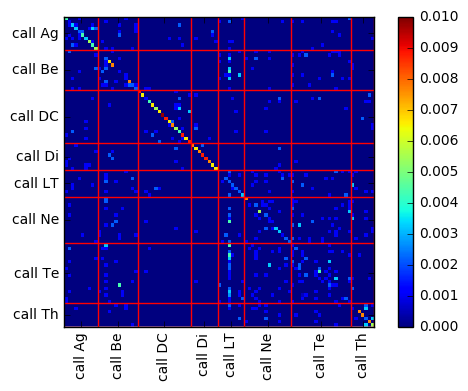

In [7]:
plot_confusion_matrix(conf, table, labels)
plt.clim(0, 0.01)
plt.colorbar()
plt.show()

### Mutual Information

The mutual information of the confusion matrix $C$, whose elements $c_{ij}$ represent the joint probability $p(s'_i, s_j)$, is the following:

$I(S'|S) = \sum\limits_i \sum\limits_j c_{ij} \log_2\frac{c_{ij}}{p(s'_i)p(s_j)}$

where 

$p(s'_i) = \sum\limits_j {c_{ij}}$

$p(s_i) = \sum\limits_j {c_{ji}}$

In [8]:
print "{:.2f} / {:.2f} bits".format(conf.information(), np.log2(len(stims)))

4.01 / 6.54 bits


### By stimulus category

Finally, we will build a confusion matrix using stimulus category rather than stimulus id. This should help with sampling bias becuase there are several more datapoints per stimulus category, but the overall information possible is still low.

In [9]:
# Now try it by stim type
selectors, stim_types = template_selectors(table, key="stim_type")
distances = compute_euclidian_distances_to_all_templates(psths, selectors)
predicted = compute_nearest_template_with_ties(distances, stim_types)

In [10]:
conf = ConfusionMatrix(table["stim_type"], predicted)

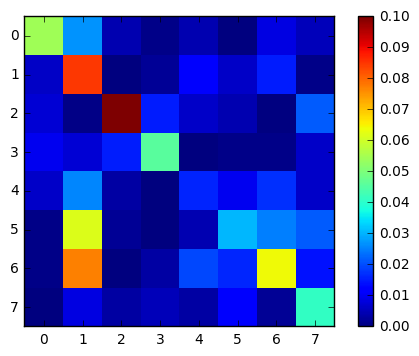

In [11]:
plot_confusion_matrix(conf)
plt.clim(0, 0.1)
plt.colorbar()
plt.show()

In [79]:
print "{:.2f} / {:.2f} bits".format(conf.information(), np.log2(len(stim_types)))

0.12 / 3.00 bits
